Original Shape: (10000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction_id         10000 non-null  object 
 1   timestamp              10000 non-null  object 
 2   amount                 10000 non-null  float64
 3   merchant_category      10000 non-null  object 
 4   customer_id            10000 non-null  object 
 5   customer_age           10000 non-null  int64  
 6   customer_location      10000 non-null  object 
 7   device_type            10000 non-null  object 
 8   previous_transactions  10000 non-null  int64  
 9   is_fraud               10000 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 781.4+ KB
None
Dropped rows: 0


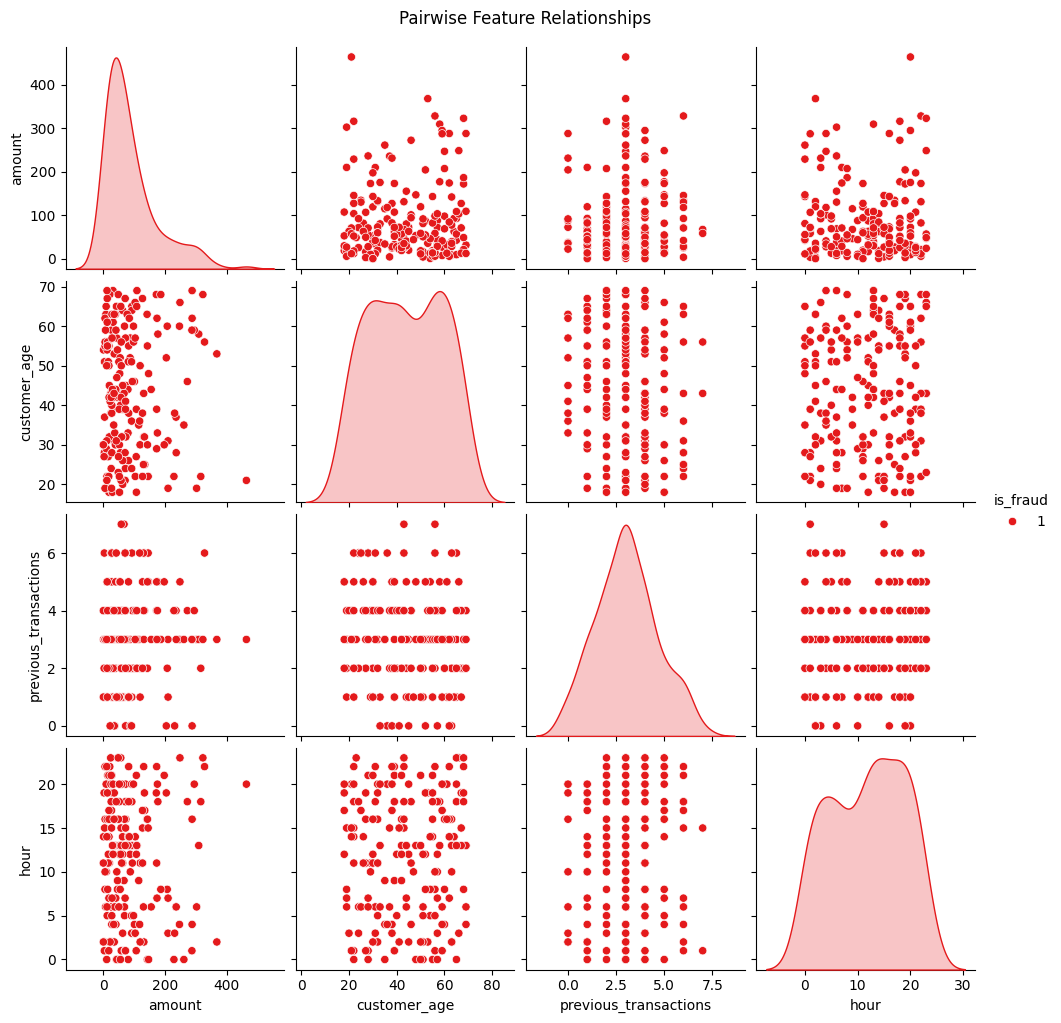

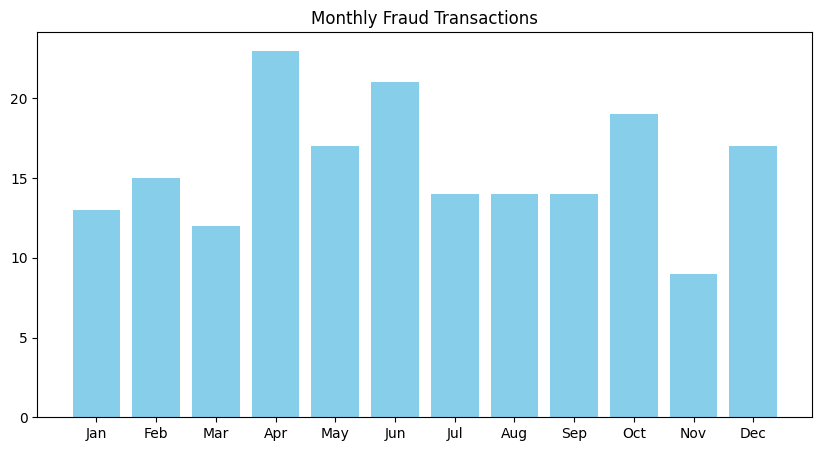

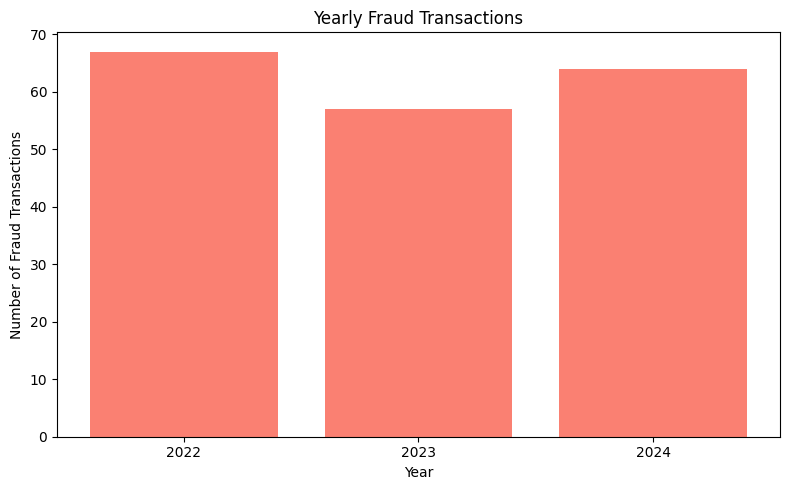

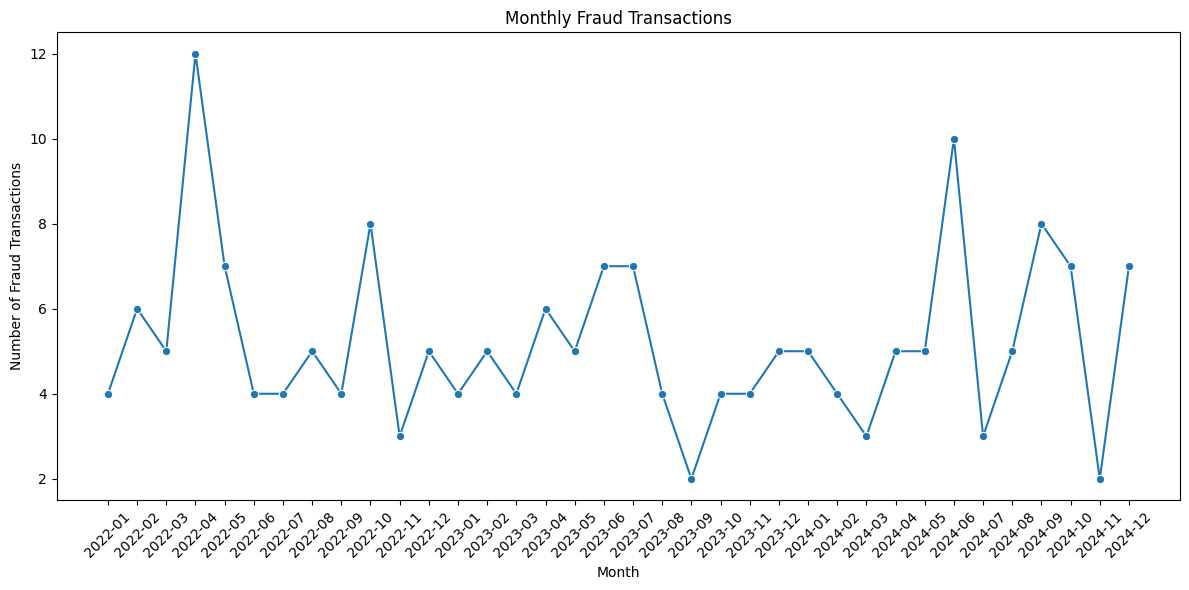

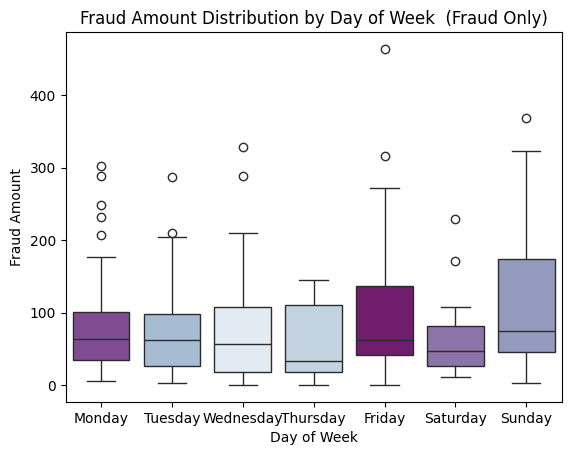

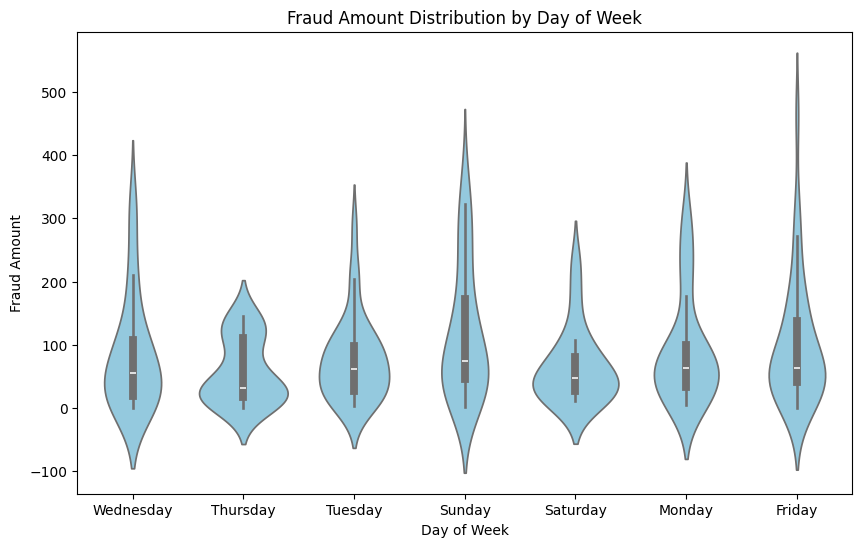

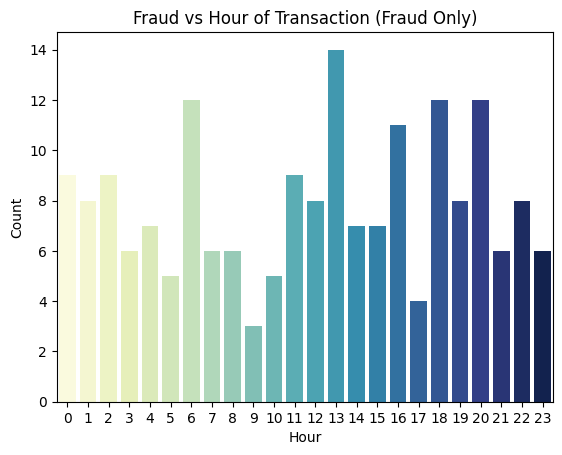

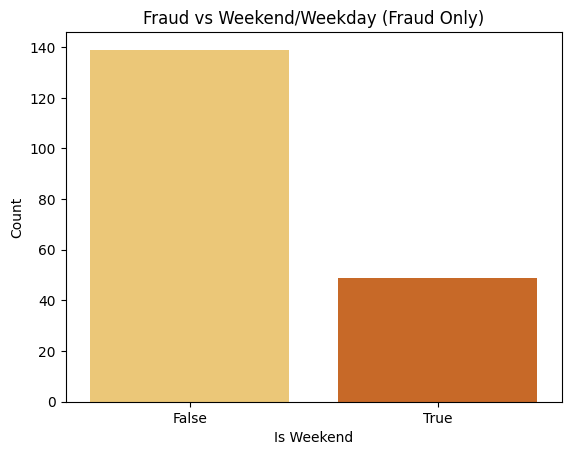

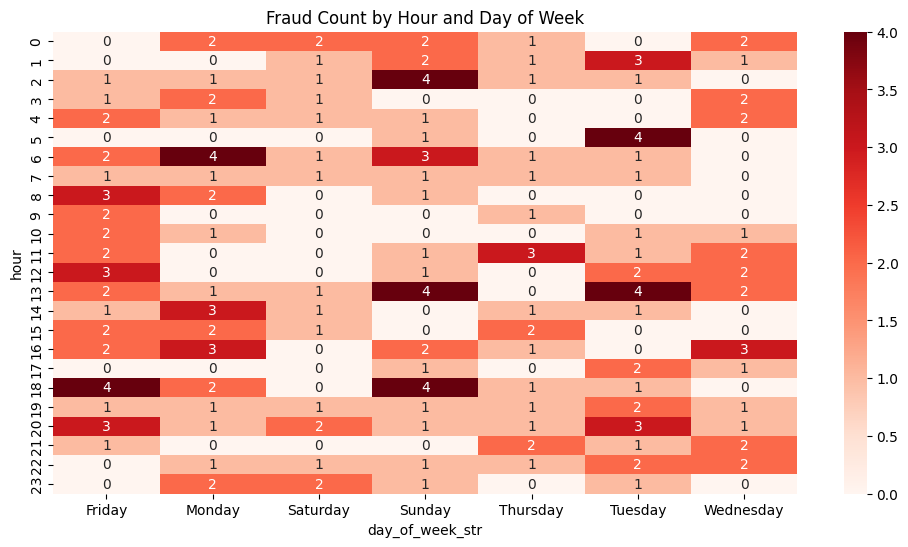

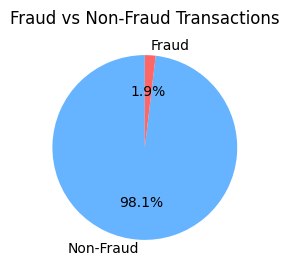

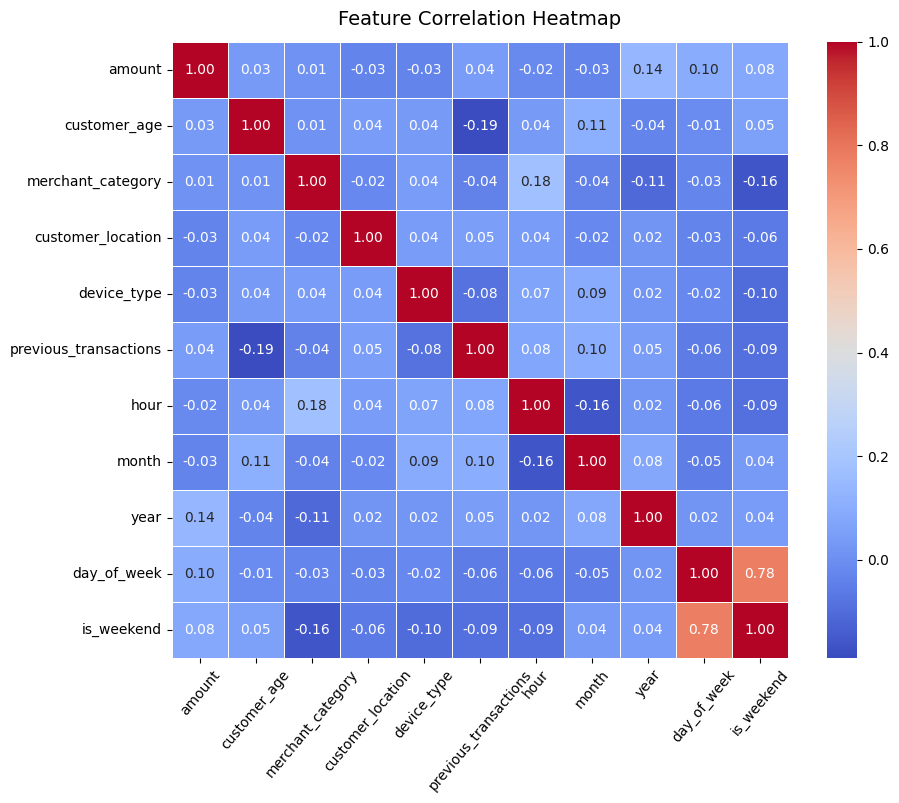

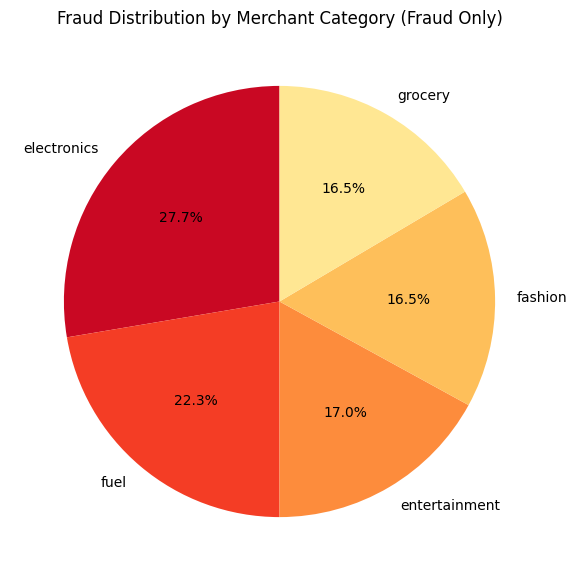

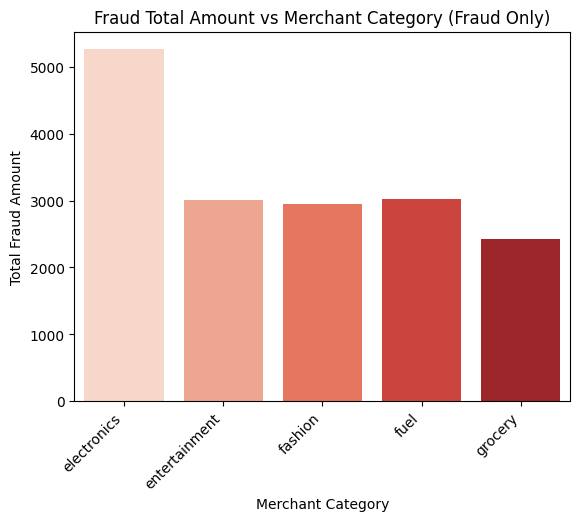

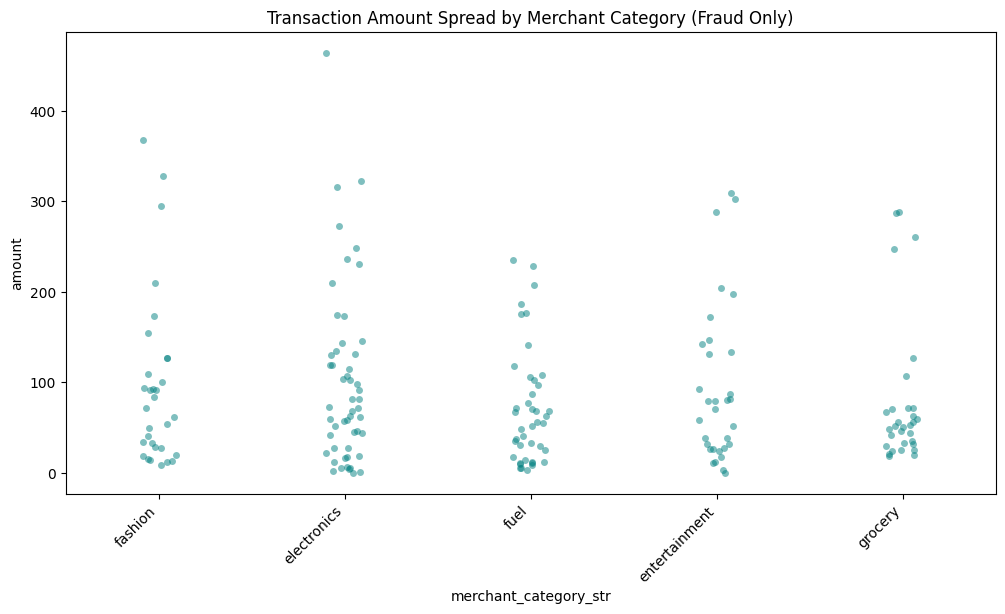

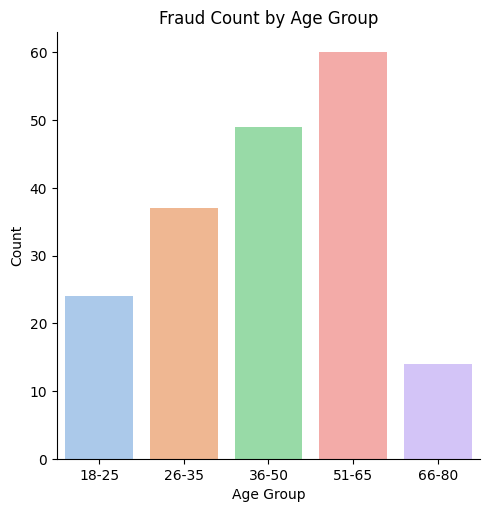

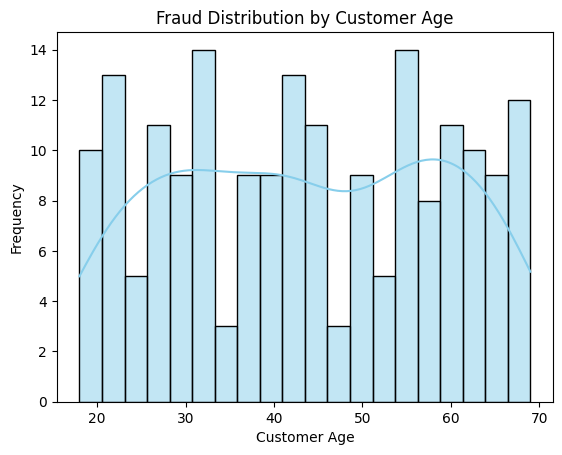

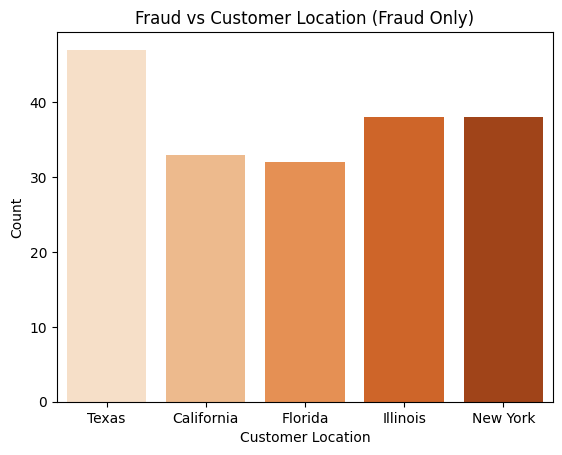

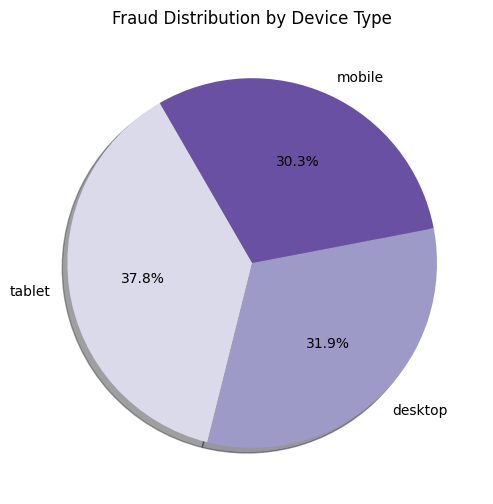

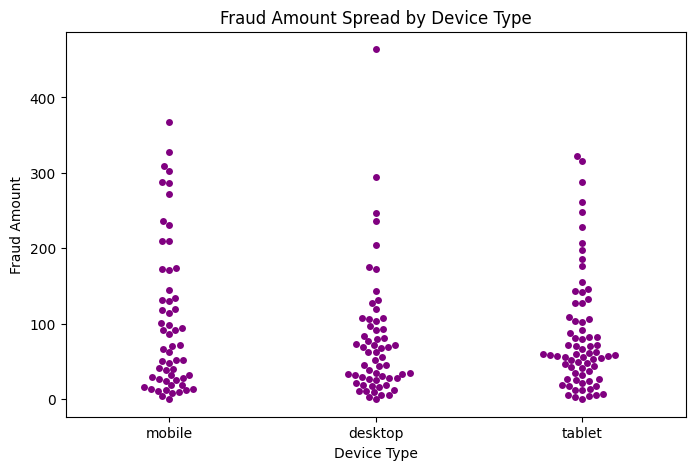

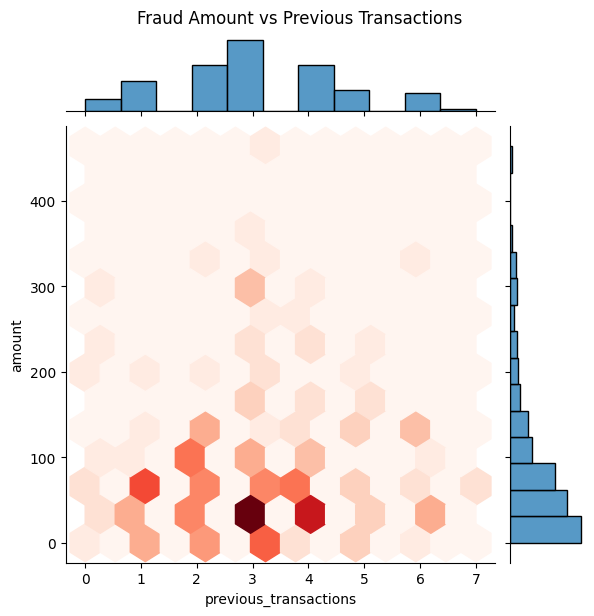

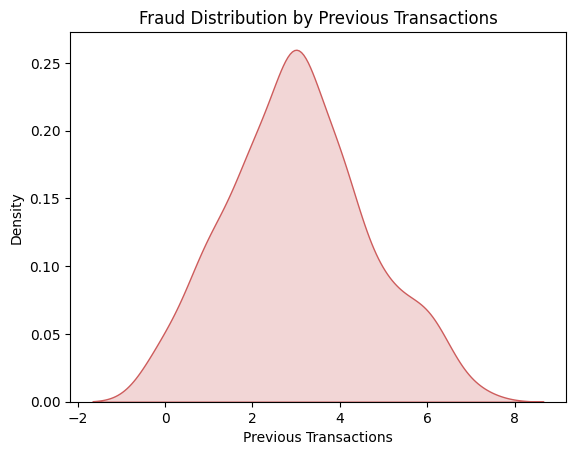

===== FRAUD AMOUNT SUMMARY =====
Total transaction amount: $977,499.72
Total fraud amount:       $16,663.49
Fraud percentage by amount: 1.70%
Fraud cases: 188 (1.88%)

Fraud Amount by Merchant Category:
merchant_category_str
electronics      5264.33
fuel             3016.93
entertainment    3000.72
fashion          2951.08
grocery          2430.43
Name: amount, dtype: float64

Fraud Amount by Month:
month_str
Jan    1292.80
Feb    1648.86
Mar     746.55
Apr    2009.25
May    1818.61
Jun    1754.26
Jul    1082.88
Aug    1350.52
Sep    1292.38
Oct    1141.78
Nov     731.12
Dec    1794.48
Name: amount, dtype: float64

===========================Key Insights from EDA==================================

> Out of a total transaction amount of $977,499.72, about $16,663.49 was fraudulent 
  — meaning fraud accounted for ~1.7% of the money moved, even though only 1.9% of 
  the transactions were fraud (188 cases).

1. Merchant Category
   * Fraud losses were highest in Electronics: $5,264.33
  

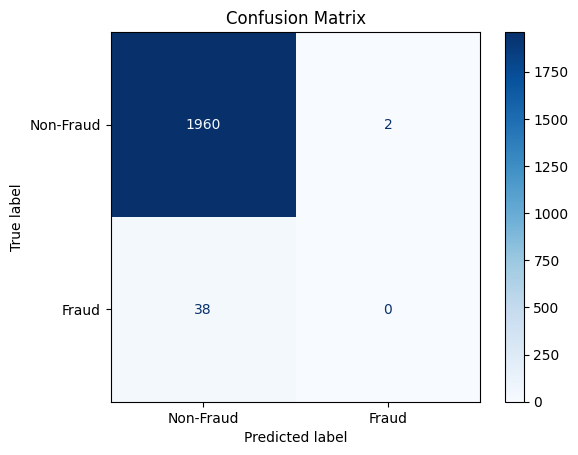

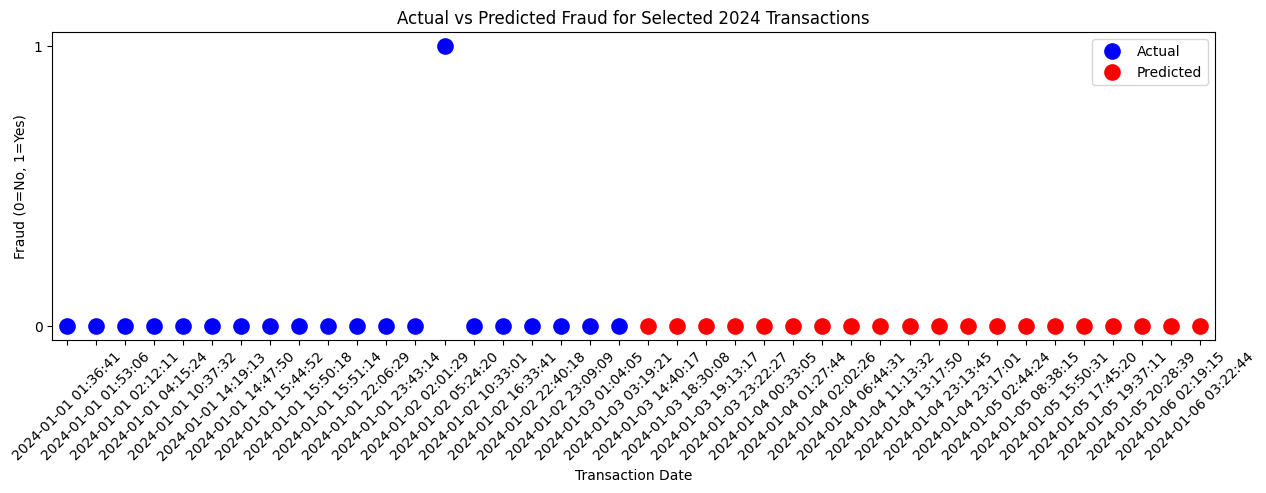

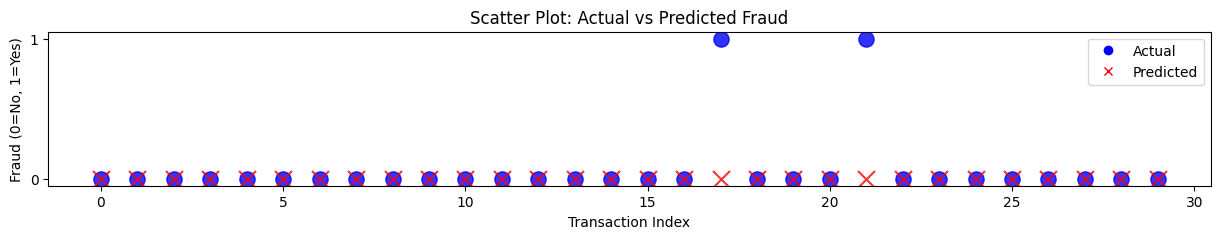

sql_df saved locally as fraud_transactions_for_sql.csv


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from matplotlib.lines import Line2D


# Load & Clean Data
df = pd.read_csv("./datasets/financial_fraud_dataset.csv")

old_shape = df.shape
print("Original Shape:", old_shape)
print(df.info())

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Drop missing & duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

print("Dropped rows:", df.shape[0] - old_shape[0])

# Encode device type
df['device_type'] = df['device_type'].map({'tablet': 0, 'mobile': 1, 'desktop': 2})


# Feature Engineering

df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5

# Encode categorical variables
df['customer_location'] = df['customer_location'].map({'NY': 0, 'IL': 1, 'TX': 2, 'FL': 3, 'CA': 4})
df['merchant_category'] = df['merchant_category'].map({'fuel': 0, 'electronics': 1, 'entertainment': 2, 'fashion': 3, 'grocery': 4})

# Mapping dictionaries
merchant_map = {0: 'fuel', 1: 'electronics', 2: 'entertainment', 3: 'fashion', 4: 'grocery'}
location_map = {0: 'New York', 1: 'Illinois', 2: 'Texas', 3: 'Florida', 4: 'California'}
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
device_map = {0: 'tablet', 1: 'mobile', 2: 'desktop'}

# Mapping columns
df['merchant_category_str'] = df['merchant_category'].map(merchant_map)
df['customer_location_str'] = df['customer_location'].map(location_map)
df['day_of_week_str'] = df['day_of_week'].map(day_map)
df['device_type_str'] = df['device_type'].map(device_map)

# More features
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df['month_str'] = df['month'].map(month_map)

features = ["amount","customer_age","merchant_category","customer_location",
            "device_type","previous_transactions","hour","month","year",
            "day_of_week","is_weekend"]

fraud_df = df[df['is_fraud'] == 1]


# Exploratory Data Analysis (EDA)

# Pairplot: relationships between key numeric features
sns.pairplot(
    fraud_df[['amount','customer_age','previous_transactions','hour','is_fraud']], 
    hue='is_fraud', palette='Set1', diag_kind='kde'
)
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

#   Monthly fraud counts (aggregated across years)  
monthly_fraud_counts = fraud_df.groupby('month_str').size().reindex(month_map.values(), fill_value=0)
plt.figure(figsize=(10,5))
plt.bar(monthly_fraud_counts.index, monthly_fraud_counts.values, color="skyblue")
plt.title("Monthly Fraud Transactions")
plt.show()

#   Yearly fraud counts  
yearly_fraud_counts = fraud_df.groupby('year').size().reset_index(name='count')

yearly_fraud_counts = yearly_fraud_counts.sort_values('year')

# Plot
plt.figure(figsize=(8,5))
plt.bar(yearly_fraud_counts['year'].astype(str), yearly_fraud_counts['count'], color='salmon')
plt.xlabel('Year')
plt.ylabel('Number of Fraud Transactions')
plt.title('Yearly Fraud Transactions')
plt.tight_layout()
plt.show()

# Count frauds per date 
fraud_counts_on_date = fraud_df.groupby('date').size().reset_index(name='count')
# Convert 'date' to period month
fraud_counts_on_date['month_str'] = pd.to_datetime(fraud_counts_on_date['date']).dt.to_period('M')
# Aggregate counts per month
monthly_counts = fraud_counts_on_date.groupby('month_str')['count'].sum().reset_index()

# Plot monthly counts
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_counts['month_str'].astype(str), y=monthly_counts['count'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Fraud Transactions')
plt.title('Monthly Fraud Transactions')
plt.tight_layout()
plt.show()

# Fraud vs Day of Week
sns.boxplot(x='day_of_week_str',y='amount',hue='day_of_week_str', data=fraud_df,order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],palette='BuPu',legend=False)
plt.title('Fraud Amount Distribution by Day of Week  (Fraud Only)')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Amount')
plt.show()

# Violin Plot: Distribution of fraud amount by day of week
plt.figure(figsize=(10,6))
sns.violinplot(x='day_of_week_str', y='amount', data=fraud_df, color='skyblue')
plt.title('Fraud Amount Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Amount')
plt.show()

# Fraud vs Hour of Transaction
sns.countplot(x='hour', hue='hour', data=fraud_df, palette='YlGnBu', legend=False)
plt.title('Fraud vs Hour of Transaction (Fraud Only)')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

# Fraud vs Weekend/Weekday
sns.countplot(x='is_weekend', hue='is_weekend', data=fraud_df, palette='YlOrBr', legend=False)
plt.title('Fraud vs Weekend/Weekday (Fraud Only)')
plt.xlabel('Is Weekend')
plt.ylabel('Count')
plt.show()

# Heatmap: Fraud count by Hour and Day
fraud_density = fraud_df.groupby(['hour', 'day_of_week_str']).size().unstack(fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(fraud_density, annot=True, fmt='d', cmap='Reds')
plt.title('Fraud Count by Hour and Day of Week')
plt.show()

# Percentage of Fraud vs Non-Fraud
fraud_counts = df['is_fraud'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'], startangle=90)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

# Feature Correlation Heatmap
corr = fraud_df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot=True,fmt=".2f",cmap="coolwarm",cbar=True,square=True,linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.xticks(rotation=50)
plt.show()

# Fraud vs Merchant Category

# Count of frauds per merchant category
fraud_counts_by_category = fraud_df['merchant_category_str'].value_counts().sort_values(ascending=False)

# Plot pie chart with percentages
plt.figure(figsize=(7,7))
plt.pie(
    fraud_counts_by_category,
    labels=fraud_counts_by_category.index,
    autopct='%1.1f%%',  # show percentage
    startangle=90,
    colors=sns.color_palette("YlOrRd", len(fraud_counts_by_category))[::-1]  # reversed palette
)
plt.title('Fraud Distribution by Merchant Category (Fraud Only)')
plt.show()


# Fraud Total Amount vs Merchant Category
fraud_amount_by_category = fraud_df.groupby('merchant_category_str')['amount'].sum().reset_index()

sns.barplot(x='merchant_category_str',y='amount',hue='merchant_category_str',data=fraud_amount_by_category,palette='Reds')

plt.title('Fraud Total Amount vs Merchant Category (Fraud Only)')
plt.xlabel('Merchant Category')
plt.ylabel('Total Fraud Amount')
plt.xticks(rotation=45, ha='right')
plt.show()

# Strip Plot: Transaction amount vs Merchant Category
plt.figure(figsize=(12,6))
sns.stripplot(x='merchant_category_str', y='amount', data=fraud_df, 
              jitter=True, alpha=0.5, color='teal')
plt.title('Transaction Amount Spread by Merchant Category (Fraud Only)')
plt.xticks(rotation=45, ha='right')
plt.show()


# Catplot: Fraud by customer age buckets
fraud_df = fraud_df.copy()  # ensure safe modification
fraud_df['age_group'] = pd.cut(
    fraud_df['customer_age'], 
    bins=[18,25,35,50,65,80], 
    labels=['18-25','26-35','36-50','51-65','66-80']
)

sns.catplot(x='age_group', hue='age_group', kind='count', data=fraud_df, 
            palette='pastel', legend=False)
plt.title('Fraud Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

# Fraud vs Customer Age (use histogram for distribution)
sns.histplot(fraud_df['customer_age'], bins=20, kde=True, color='skyblue')
plt.title('Fraud Distribution by Customer Age')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.show()

# Fraud vs Customer Location
sns.countplot(x='customer_location_str', hue='customer_location_str', data=fraud_df, palette='Oranges', legend=False)
plt.title('Fraud vs Customer Location (Fraud Only)')
plt.xlabel('Customer Location')
plt.ylabel('Count')
plt.show()

# Fraud vs Device Type (Pie Chart)
fraud_device_counts = fraud_df['device_type_str'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(fraud_device_counts,labels=fraud_device_counts.index,autopct='%1.1f%%',shadow=True,startangle=120,colors=sns.color_palette('Purples', len(fraud_device_counts)))
plt.title('Fraud Distribution by Device Type')
plt.show()

# Swarm Plot: Fraud amount vs Device Type
plt.figure(figsize=(8,5))
sns.swarmplot(x='device_type_str', y='amount', data=fraud_df, color='purple', size=5)
plt.title('Fraud Amount Spread by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Fraud Amount')
plt.show()


# Joint Plot: Fraud amount vs Previous Transactions
sns.jointplot(x='previous_transactions', y='amount', data=fraud_df, kind='hex', cmap='Reds')
plt.suptitle("Fraud Amount vs Previous Transactions", y=1.02)
plt.show()

# Fraud vs Previous Transactions (use KDE for density)
sns.kdeplot(fraud_df['previous_transactions'], fill=True, color='indianred')
plt.title('Fraud Distribution by Previous Transactions')
plt.xlabel('Previous Transactions')
plt.ylabel('Density')
plt.show()


# Summary Stats
total_transactions = len(df)
total_frauds = df['is_fraud'].sum()
fraud_percentage = (total_frauds / total_transactions) * 100
total_amount = df['amount'].sum()

# 2. Total fraud amount
fraud_amount_total = df.loc[df['is_fraud'] == 1, 'amount'].sum()
print("===== FRAUD AMOUNT SUMMARY =====")
print(f"Total transaction amount: ${total_amount:,.2f}")
print(f"Total fraud amount:       ${fraud_amount_total:,.2f}")
print(f"Fraud percentage by amount: {(fraud_amount_total / total_amount) * 100:.2f}%")
print(f"Fraud cases: {total_frauds} ({fraud_percentage:.2f}%)")

# 3. Fraud amount by merchant category
fraud_amount_by_category = (
    df[df['is_fraud'] == 1]
    .groupby('merchant_category_str')['amount']
    .sum()
    .sort_values(ascending=False)
)

print("\nFraud Amount by Merchant Category:")
print(fraud_amount_by_category)

# 4. Fraud amount by month
fraud_amount_by_month = (
    df[df['is_fraud'] == 1]
    .groupby('month_str')['amount']
    .sum()
    .reindex(month_map.values(), fill_value=0)  # keep calendar order
)

print("\nFraud Amount by Month:")
print(fraud_amount_by_month)

eda_text = """
===========================Key Insights from EDA==================================

> Out of a total transaction amount of $977,499.72, about $16,663.49 was fraudulent 
  — meaning fraud accounted for ~1.7% of the money moved, even though only 1.9% of 
  the transactions were fraud (188 cases).

1. Merchant Category
   * Fraud losses were highest in Electronics: $5,264.33
   * Next highest were Fuel: $3,016.93 and Entertainment: $3,000.72
   * Fashion: $2,951.08 and Grocery: $2,430.43 had lower but notable fraud
   * Electronics alone made up nearly one-third of total fraud amount

2. Customer Age
   * Fraud incidents occurred across almost all age groups
   * Peak fraud activity was observed among customers aged 52 to 68 years

3. Customer Location
   * Highest fraud cases were in Texas, followed by New York and California
   * Florida had the lowest fraud cases among all regions

4. Device Type
   * Fraud cases were highest on Tablets: 71 cases
   * Next were Desktops: 60 cases and Mobiles: 57 cases

5. Previous Transactions
   * Customers with 3 prior transactions (54 cases) showed the highest fraud occurrence
   * Fraud risk did not increase linearly with more transactions

6. Hour of Transaction
   * Fraud peaked at 13:00 (1 PM)
   * Additional spikes at 06:00, 18:00, and 20:00
   * In general, fraud was higher between 9 AM – 3 PM and again during evening hours
   * Lowest fraud occurred between midnight to 5 AM

7. Day of Week
   * Fraud was most frequent on Fridays: 35 cases
   * Lowest on Saturday: 17 cases
   * Overall, fraud was more common on weekdays (139 cases) than weekends (49 cases)

8. Year and Month Trends
   * Fraud cases peaked in 2022, with the next highest in 2024
   * By fraud amount, top months were:
       - April: $2,009.25
       - May: $1,818.61
       - June: $1,754.26
       - December: $1,794.48
   * Lowest months:
       - November: $731.12
       - March: $746.55
   * July to September showed steady moderate fraud amounts ($1,082.88 – $1,350.52)
"""

print(eda_text)



# Model Training
print("\n===========================Training ML Model for Prediction==================================\n")

# features = ["amount","customer_age","merchant_category","customer_location",
#             "device_type","previous_transactions","hour","month","year",
#             "day_of_week","is_weekend"]


X = df[features]
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42, class_weight="balanced"
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

joblib.dump(model, "./models/fraud_model.pkl")
print("Model saved as fraud_model.pkl in models folder")

# ================= Analysis: ML Model =================
print("\n=========================== Analysis of ML Model ===========================\n")

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ================= Actual vs Predicted (2024 Transactions) =================
# Filter 2024 transactions and sort by timestamp  
df_2024 = df[df['year'] == 2024].sort_values('timestamp').head(40)  

df_actual = df_2024.iloc[:20].copy()
df_predict = df_2024.iloc[20:].copy()

# Predict fraud for remaining
df_predict['is_fraud_pred'] = model.predict(df_predict[features])

# Combine for plotting
df_plot = pd.concat([
    df_actual.assign(type='Actual', is_fraud_pred=df_actual['is_fraud']),
    df_predict.assign(type='Predicted')
])

# Plot Actual vs Predicted
plt.figure(figsize=(15,4))
sns.stripplot(
    x='timestamp',
    y='is_fraud_pred',
    hue='type',
    data=df_plot,
    palette={'Actual':'blue', 'Predicted':'red'},
    size=12
)
plt.xticks(rotation=45)
plt.yticks([0,1])
plt.xlabel('Transaction Date')
plt.ylabel('Fraud (0=No, 1=Yes)')
plt.title('Actual vs Predicted Fraud for Selected 2024 Transactions')
plt.legend(title='')
plt.show()

# ================= Scatter Plot: Actual vs Predicted =================
# Convert to numpy arrays
y_test_np = y_test.values
y_pred_np = y_pred
x = np.arange(len(y_test_np))  # transaction index

# Optional: plot a subset for clarity
sample_size = 30
x_sample = x[:sample_size]
y_test_sample = y_test_np[:sample_size]
y_pred_sample = y_pred_np[:sample_size]

# Scatter Plot 
plt.figure(figsize=(15,2))
plt.scatter(x_sample, y_test_sample, color='blue', alpha=0.8, s=120, label='Actual')
plt.scatter(x_sample, y_pred_sample, color='red', alpha=0.8, s=150, marker='x', label='Predicted')

# Custom legend
custom_lines = [
    Line2D([0], [0], color='blue', marker='o', linestyle='None'),
    Line2D([0], [0], color='red', marker='x', linestyle='None')
]
plt.legend(custom_lines, ['Actual', 'Predicted'])

plt.title('Scatter Plot: Actual vs Predicted Fraud')
plt.xlabel('Transaction Index')
plt.ylabel('Fraud (0=No, 1=Yes)')
plt.yticks([0,1])
plt.show()


# Save SQL-Ready Data

sql_df = df[['transaction_id','timestamp','amount','customer_id','customer_age',
             'previous_transactions','hour','is_weekend',
             'merchant_category_str','customer_location_str',
             'day_of_week_str','device_type_str','is_fraud']].copy()

sql_df.rename(columns={
    'merchant_category_str': 'merchant_category',
    'customer_location_str': 'customer_location',
    'day_of_week_str': 'day_of_week',
    'device_type_str': 'device_type'
}, inplace=True)

sql_df.to_csv("fraud_transactions_for_sql.csv", index=False)
print("sql_df saved locally as fraud_transactions_for_sql.csv")